# ***MNIST, clasificación de dígitos***
Visualización de datos sobre un dataset MNIST de dígitos escritos a mano (0-9). Este conjunto de datos contiene 70,000 imágenes en escala de grises de 28x28 píxeles, cada una representando un dígito individual. El objetivo principal será evaluar e implementar un pipeline completo de ML para clasificación de imágenes.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from tensorflow import keras

In [66]:
(train_data, train_label), (test_data, test_label) = keras.datasets.mnist.load_data()

In [67]:
print('Train data: ' + str(train_data.shape))
print('Train labels: ' + str(train_label.shape))
print('Test data:  '  + str(test_data.shape))
print('Test labels:  '  + str(test_label.shape))

Train data: (60000, 28, 28)
Train labels: (60000,)
Test data:  (10000, 28, 28)
Test labels:  (10000,)


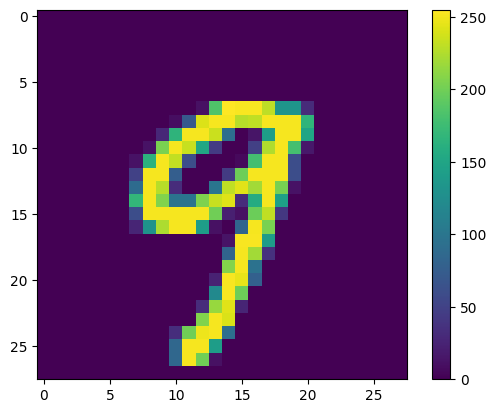

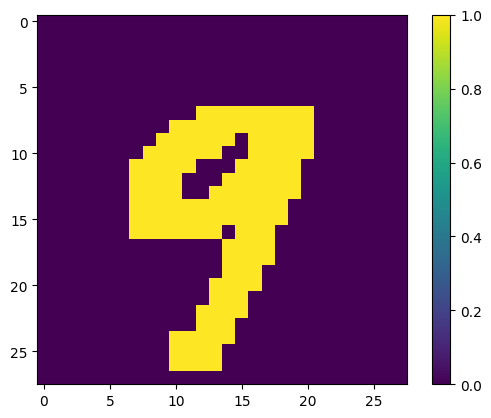

In [68]:
plt.imshow(train_data[45])
plt.colorbar()
plt.show()
plt.imshow(train_data[45] > 0)
plt.colorbar()
plt.show()

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando: {device}")

Usando: cpu


In [70]:
torch.manual_seed(42)
np.random.seed(42)

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Detectar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VisualizadorMNIST:
    """
    Clase para visualizar y analizar el dataset MNIST de dígitos escritos a mano.
    Incluye funcionalidades para entrenar una CNN simple y visualizar características aprendidas.
    """

    def __init__(self):
        """
        Inicializa el visualizador configurando las transformaciones y cargando los datos.
        """
        # Definir transformaciones: convertir a tensor y normalizar
        # Los valores (0.1307,) y (0.3081,) son la media y desviación estándar de MNIST
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convierte PIL Image a tensor y escala [0,1]
            transforms.Normalize((0.1307,), (0.3081,))  # Normaliza con media=0.1307, std=0.3081
        ])

        # Cargar dataset de entrenamiento
        self.train_dataset = torchvision.datasets.MNIST(
            root='./data',          # Directorio donde guardar/cargar los datos
            train=True,             # Conjunto de entrenamiento
            download=True,          # Descargar si no existe
            transform=self.transform # Aplicar transformaciones
        )

        # Cargar dataset de prueba
        self.test_dataset = torchvision.datasets.MNIST(
            root='./data',
            train=False,            # Conjunto de prueba
            download=True,
            transform=self.transform
        )

        # Crear DataLoaders para cargar datos en lotes
        self.train_loader = DataLoader(self.train_dataset, batch_size=64, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=64, shuffle=False)

    def informacion_basica_dataset(self):
        """
        Muestra información básica sobre el dataset MNIST y visualiza la distribución de clases.
        """
        print("=== Información del Dataset MNIST ===")
        print(f"Muestras de entrenamiento: {len(self.train_dataset)}")
        print(f"Muestras de prueba: {len(self.test_dataset)}")
        print(f"Número de clases: {len(self.train_dataset.classes)}")
        print(f"Clases: {self.train_dataset.classes}")
        print(f"Forma de la imagen: {self.train_dataset[0][0].shape}")

        # Extraer todas las etiquetas del conjunto de entrenamiento
        train_labels = [self.train_dataset[i][1] for i in range(len(self.train_dataset))]
        unique, counts = np.unique(train_labels, return_counts=True)

        # Crear visualizaciones de la distribución de clases
        plt.figure(figsize=(12, 4))

        # Gráfico de barras
        plt.subplot(1, 2, 1)
        plt.bar(unique, counts)
        plt.title('Distribución de Datos de Entrenamiento por Clase')
        plt.xlabel('Clase de Dígito')
        plt.ylabel('Número de Muestras')

        # Gráfico de pastel
        plt.subplot(1, 2, 2)
        plt.pie(counts, labels=unique, autopct='%1.1f%%')
        plt.title('Distribución de Datos de Entrenamiento (Porcentaje)')
        plt.tight_layout()
        plt.show()

    def visualizar_imagenes_muestra(self, num_samples=20):
        """
        Visualiza imágenes de ejemplo de cada clase de dígito.

        Args:
            num_samples (int): Número total de muestras a mostrar (debe ser múltiplo de 10)
        """
        fig, axes = plt.subplots(10, num_samples//10, figsize=(15, 12))
        fig.suptitle('Imágenes de Muestra de Cada Clase', fontsize=16)

        # Para cada dígito (0-9)
        for digit in range(10):
            # Encontrar todos los índices que corresponden a este dígito
            digit_indices = [i for i, (_, label) in enumerate(self.train_dataset) if label == digit]
            # Seleccionar aleatoriamente algunas muestras
            selected_indices = np.random.choice(digit_indices, num_samples//10, replace=False)

            # Mostrar cada imagen seleccionada
            for i, idx in enumerate(selected_indices):
                image, label = self.train_dataset[idx]
                # Desnormalizar la imagen para visualización
                image = image.squeeze() * 0.3081 + 0.1307

                axes[digit, i].imshow(image, cmap='gray')
                axes[digit, i].set_title(f'Clase: {label}')
                axes[digit, i].axis('off')

        plt.tight_layout()
        plt.show()

    def visualizar_estadisticas_intensidad_pixeles(self):
        """
        Analiza y visualiza las estadísticas de intensidad de píxeles del dataset.
        Muestra distribuciones generales y por clase.
        """
        # Usar una muestra para eficiencia computacional
        sample_size = 1000
        indices = np.random.choice(len(self.train_dataset), sample_size, replace=False)
        subset = Subset(self.train_dataset, indices)

        pixel_intensities = []
        labels = []

        # Extraer intensidades de píxeles y etiquetas
        for image, label in subset:
            # Desnormalizar la imagen
            image = image.squeeze() * 0.3081 + 0.1307
            # Aplanar la imagen y añadir a la lista
            pixel_intensities.extend(image.flatten().numpy())
            # Repetir la etiqueta para cada píxel (28*28 = 784 píxeles por imagen)
            labels.extend([label] * (28 * 28))

        plt.figure(figsize=(15, 5))

        # Histograma general de intensidades
        plt.subplot(1, 3, 1)
        plt.hist(pixel_intensities, bins=50, alpha=0.7, color='blue')
        plt.title('Distribución General de Intensidad de Píxeles')
        plt.xlabel('Intensidad de Píxel')
        plt.ylabel('Frecuencia')

        # Histogramas por clase
        plt.subplot(1, 3, 2)
        df = pd.DataFrame({'intensity': pixel_intensities, 'class': labels})
        for digit in range(10):
            class_intensities = df[df['class'] == digit]['intensity']
            plt.hist(class_intensities, bins=30, alpha=0.5, label=f'Clase {digit}')
        plt.title('Distribución de Intensidad de Píxeles por Clase')
        plt.xlabel('Intensidad de Píxel')
        plt.ylabel('Frecuencia')
        plt.legend()

        # Diagrama de cajas por clase
        plt.subplot(1, 3, 3)
        class_data = [df[df['class'] == digit]['intensity'].values for digit in range(10)]
        plt.boxplot(class_data, labels=range(10))
        plt.title('Diagrama de Cajas de Intensidad de Píxeles por Clase')
        plt.xlabel('Clase de Dígito')
        plt.ylabel('Intensidad de Píxel')

        plt.tight_layout()
        plt.show()

    def visualizar_imagenes_promedio(self):
        """
        Calcula y visualiza la imagen promedio para cada clase de dígito.
        Útil para ver los patrones comunes en cada dígito.
        """
        # Inicializar acumuladores para cada clase
        class_sums = {i: torch.zeros(28, 28) for i in range(10)}
        class_counts = {i: 0 for i in range(10)}

        # Sumar todas las imágenes por clase
        for image, label in self.train_dataset:
            # Desnormalizar la imagen
            image = image.squeeze() * 0.3081 + 0.1307
            class_sums[label] += image
            class_counts[label] += 1

        # Calcular promedios
        class_averages = {i: class_sums[i] / class_counts[i] for i in range(10)}

        # Visualizar imágenes promedio
        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        fig.suptitle('Imágenes Promedio para Cada Clase de Dígito', fontsize=16)

        for i in range(10):
            row, col = i // 5, i % 5
            axes[row, col].imshow(class_averages[i], cmap='gray')
            axes[row, col].set_title(f'Dígito Promedio {i}')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    def crear_cnn_simple(self):
        """
        Define y retorna una CNN simple para clasificación de MNIST.

        Returns:
            SimpleCNN: Modelo de red neuronal convolucional
        """
        class CNNSimple(nn.Module):
            def __init__(self):
                super(CNNSimple, self).__init__()
                # Primera capa convolucional: 1 canal de entrada, 32 de salida, kernel 3x3
                self.conv1 = nn.Conv2d(1, 32, 3, 1)
                # Segunda capa convolucional: 32 canales de entrada, 64 de salida, kernel 3x3
                self.conv2 = nn.Conv2d(32, 64, 3, 1)
                # Capas de dropout para regularización
                self.dropout1 = nn.Dropout(0.25)  # 25% de neuronas desactivadas
                self.dropout2 = nn.Dropout(0.5)   # 50% de neuronas desactivadas
                # Capas totalmente conectadas
                self.fc1 = nn.Linear(9216, 128)   # 9216 = 64 * 12 * 12 (después de conv y pooling)
                self.fc2 = nn.Linear(128, 10)     # 10 clases de salida (dígitos 0-9)

            def forward(self, x):
                # Primera convolución + ReLU
                x = self.conv1(x)
                x = F.relu(x)
                # Segunda convolución + ReLU
                x = self.conv2(x)
                x = F.relu(x)
                # Max pooling 2x2
                x = F.max_pool2d(x, 2)
                # Dropout
                x = self.dropout1(x)
                # Aplanar para capas fully connected
                x = torch.flatten(x, 1)
                # Primera capa fully connected + ReLU
                features = self.fc1(x)  # Guardar características para visualización
                x = F.relu(features)
                # Dropout
                x = self.dropout2(x)
                # Capa de salida
                x = self.fc2(x)
                return x, features  # Retornar tanto predicciones como características

        return CNNSimple().to(device)

    def entrenar_modelo_y_extraer_caracteristicas(self, epochs=5):
        """
        Entrena el modelo CNN y retorna el modelo entrenado.

        Args:
            epochs (int): Número de épocas de entrenamiento

        Returns:
            torch.nn.Module: Modelo entrenado
        """
        model = self.crear_cnn_simple()
        optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam
        criterion = nn.CrossEntropyLoss()  # Función de pérdida para clasificación

        print("Entrenando modelo...")
        model.train()  # Poner el modelo en modo entrenamiento

        for epoch in range(epochs):
            total_loss = 0
            for batch_idx, (data, target) in enumerate(self.train_loader):
                # Mover datos a GPU si está disponible
                data, target = data.to(device), target.to(device)

                # Reiniciar gradientes
                optimizer.zero_grad()
                # Forward pass
                output, _ = model(data)
                # Calcular pérdida
                loss = criterion(output, target)
                # Backward pass
                loss.backward()
                # Actualizar pesos
                optimizer.step()
                total_loss += loss.item()

                # Imprimir progreso cada 300 lotes
                if batch_idx % 300 == 0:
                    print(f'Época {epoch+1}/{epochs}, Lote {batch_idx}, Pérdida: {loss.item():.4f}')

            print(f'Época {epoch+1} completada. Pérdida Promedio: {total_loss/len(self.train_loader):.4f}')

        return model

    def visualizar_mapas_caracteristicas(self, model, num_samples=4):
        """
        Visualiza los mapas de características de la primera capa convolucional.

        Args:
            model: Modelo entrenado
            num_samples (int): Número de muestras a visualizar
        """
        model.eval()  # Poner modelo en modo evaluación

        # Obtener algunas imágenes de prueba
        data_iter = iter(self.test_loader)
        images, labels = next(data_iter)
        images = images[:num_samples].to(device)

        # Pasar imágenes por la primera capa convolucional
        with torch.no_grad():
            conv1_output = model.conv1(images)
            conv1_output = F.relu(conv1_output)

        # Visualizar imágenes originales y mapas de características
        fig, axes = plt.subplots(num_samples, 9, figsize=(18, 8))
        fig.suptitle('Mapas de Características de la Primera Capa Convolucional', fontsize=16)

        for i in range(num_samples):
            # Imagen original
            axes[i, 0].imshow(images[i].cpu().squeeze() * 0.3081 + 0.1307, cmap='gray')
            axes[i, 0].set_title(f'Original\nEtiqueta: {labels[i]}')
            axes[i, 0].axis('off')

            # Primeros 8 mapas de características
            for j in range(8):
                axes[i, j+1].imshow(conv1_output[i, j].cpu(), cmap='viridis')
                axes[i, j+1].set_title(f'Característica {j+1}')
                axes[i, j+1].axis('off')

        plt.tight_layout()
        plt.show()

    def visualizar_caracteristicas_aprendidas_tsne(self, model, num_samples=1000):
        """
        Usa t-SNE y PCA para visualizar las características aprendidas por el modelo.

        Args:
            model: Modelo entrenado
            num_samples (int): Número de muestras para la visualización
        """
        model.eval()

        features = []
        labels = []

        # Extraer características de la capa fully connected
        with torch.no_grad():
            for i, (data, target) in enumerate(self.test_loader):
                if len(features) >= num_samples:
                    break

                data = data.to(device)
                _, feature = model(data)  # Obtener características
                features.extend(feature.cpu().numpy())
                labels.extend(target.numpy())

        features = np.array(features[:num_samples])
        labels = np.array(labels[:num_samples])

        # Aplicar t-SNE para reducción de dimensionalidad
        print("Calculando embedding t-SNE...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        features_2d = tsne.fit_transform(features)

        plt.figure(figsize=(12, 5))

        # Visualización t-SNE
        plt.subplot(1, 2, 1)
        scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter)
        plt.title('Visualización t-SNE de Características Aprendidas')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')

        # Visualización PCA
        plt.subplot(1, 2, 2)
        pca = PCA(n_components=2)
        features_pca = pca.fit_transform(features)
        scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter)
        plt.title('Visualización PCA de Características Aprendidas')
        plt.xlabel(f'CP1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
        plt.ylabel(f'CP2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')

        plt.tight_layout()
        plt.show()

    def visualizar_pesos_modelo(self, model):
        """
        Visualiza los filtros aprendidos por la primera capa convolucional.

        Args:
            model: Modelo entrenado
        """
        # Extraer pesos de la primera capa convolucional
        conv1_weights = model.conv1.weight.data.cpu()

        # Visualizar los 32 filtros 3x3
        fig, axes = plt.subplots(4, 8, figsize=(16, 8))
        fig.suptitle('Filtros Aprendidos de la Primera Capa Convolucional', fontsize=16)

        for i in range(32):
            row, col = i // 8, i % 8
            filter_weight = conv1_weights[i, 0]  # Tomar el primer canal
            axes[row, col].imshow(filter_weight, cmap='gray')
            axes[row, col].set_title(f'Filtro {i+1}')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    def crear_matriz_confusion(self, model):
        """
        Evalúa el modelo y crea una matriz de confusión.

        Args:
            model: Modelo entrenado
        """
        model.eval()
        y_true = []  # Etiquetas verdaderas
        y_pred = []  # Predicciones

        # Evaluar en conjunto de prueba
        with torch.no_grad():
            for data, target in self.test_loader:
                data = data.to(device)
                output, _ = model(data)
                pred = output.argmax(dim=1, keepdim=True)  # Obtener clase predicha
                y_true.extend(target.numpy())
                y_pred.extend(pred.cpu().numpy().flatten())

        # Importar métricas de sklearn
        from sklearn.metrics import confusion_matrix, classification_report
        cm = confusion_matrix(y_true, y_pred)

        # Visualizar matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=range(10), yticklabels=range(10))
        plt.title('Matriz de Confusión')
        plt.xlabel('Etiqueta Predicha')
        plt.ylabel('Etiqueta Verdadera')
        plt.show()

        # Imprimir reporte de clasificación
        print("\nReporte de Clasificación:")
        print(classification_report(y_true, y_pred))

        # Calcular y mostrar precisión
        accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
        print(f"\nPrecisión en Prueba: {accuracy:.4f}")

# visualizador = VisualizadorMNIST()
# visualizador.informacion_basica_dataset()
# visualizador.visualizar_imagenes_muestra()
# modelo = visualizador.entrenar_modelo_y_extraer_caracteristicas()
# visualizador.crear_matriz_confusion(modelo)

In [72]:
visualizador = VisualizadorMNIST()

=== Información del Dataset MNIST ===
Muestras de entrenamiento: 60000
Muestras de prueba: 10000
Número de clases: 10
Clases: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Forma de la imagen: torch.Size([1, 28, 28])


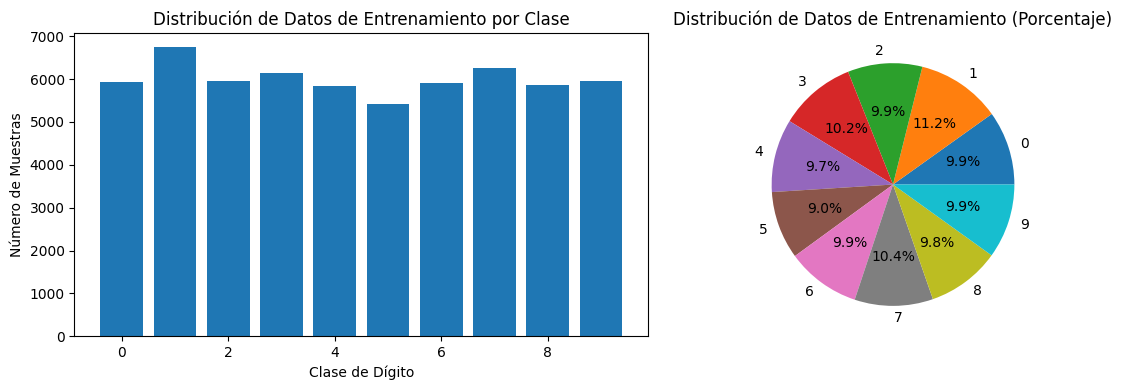

In [73]:
visualizador.informacion_basica_dataset()

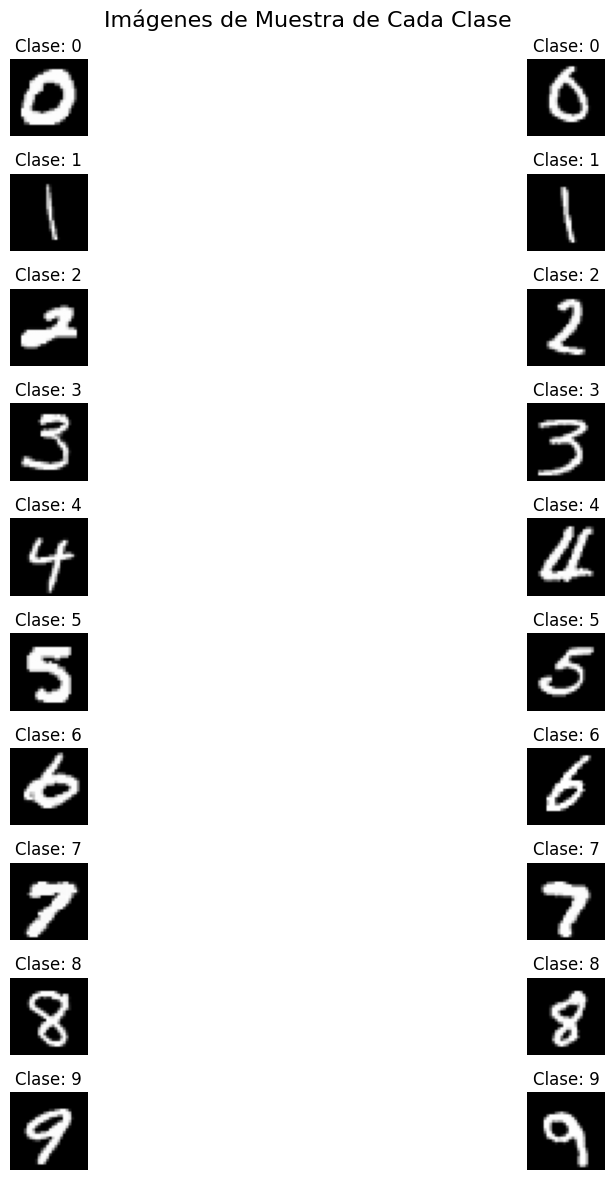

In [74]:
visualizador.visualizar_imagenes_muestra()

/tmp/ipython-input-342090341.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(class_data, labels=range(10))


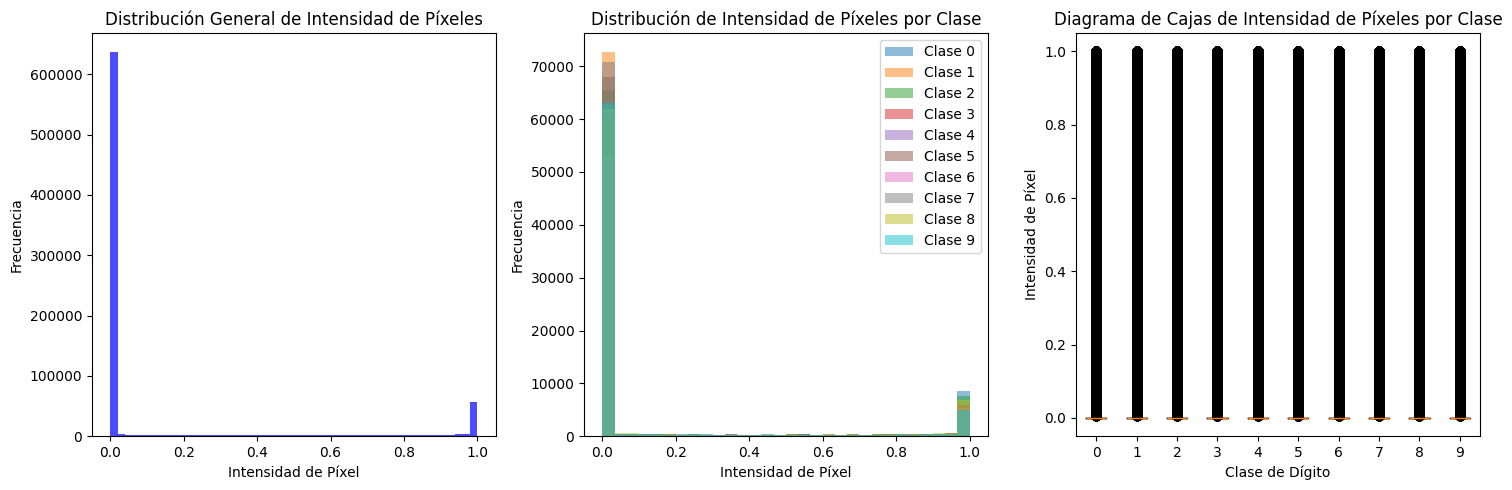

In [75]:
visualizador.visualizar_estadisticas_intensidad_pixeles()

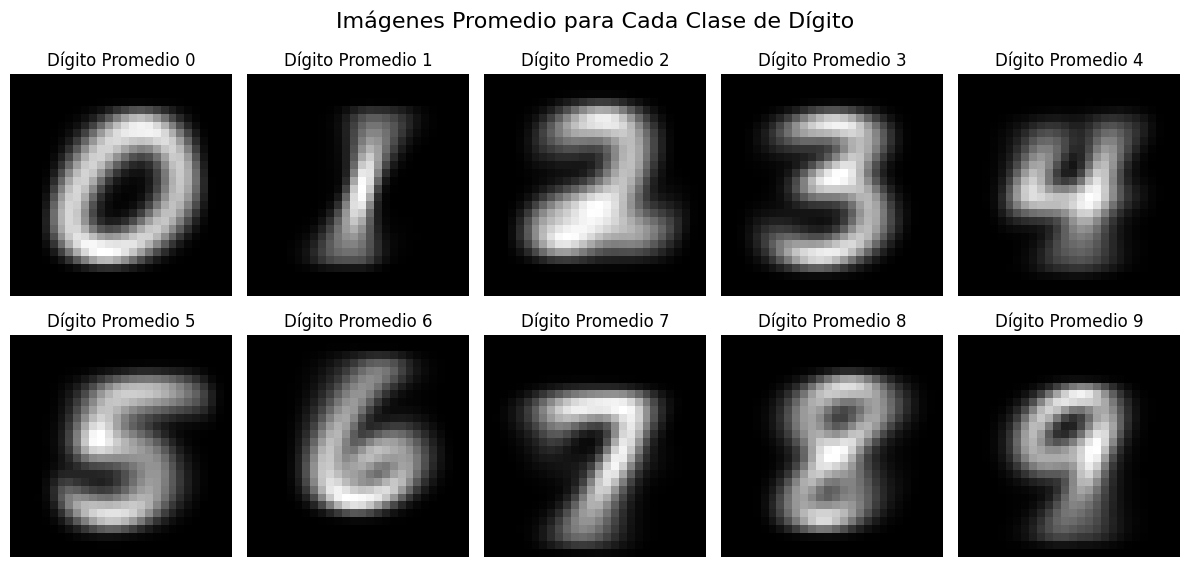

In [76]:
visualizador.visualizar_imagenes_promedio()

In [77]:
modelo = visualizador.entrenar_modelo_y_extraer_caracteristicas(epochs=2)

Entrenando modelo...
Época 1/2, Lote 0, Pérdida: 2.2953
Época 1/2, Lote 300, Pérdida: 0.0562
Época 1/2, Lote 600, Pérdida: 0.0298
Época 1/2, Lote 900, Pérdida: 0.1836
Época 1 completada. Pérdida Promedio: 0.2001
Época 2/2, Lote 0, Pérdida: 0.0471
Época 2/2, Lote 300, Pérdida: 0.0779
Época 2/2, Lote 600, Pérdida: 0.1075
Época 2/2, Lote 900, Pérdida: 0.0248
Época 2 completada. Pérdida Promedio: 0.0789


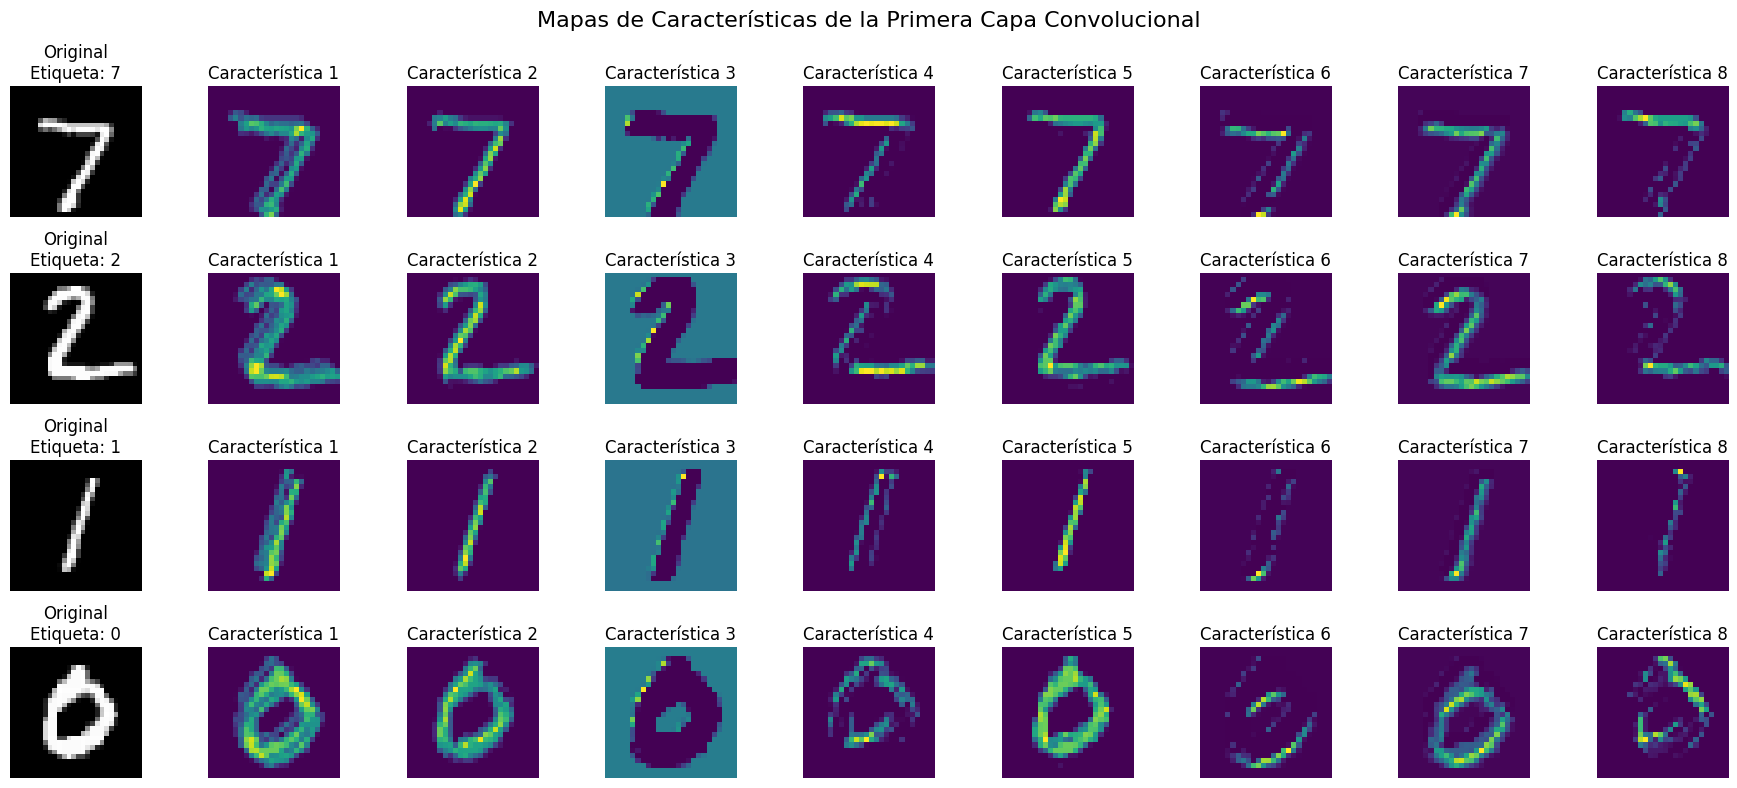

In [80]:
visualizador.visualizar_mapas_caracteristicas(modelo)

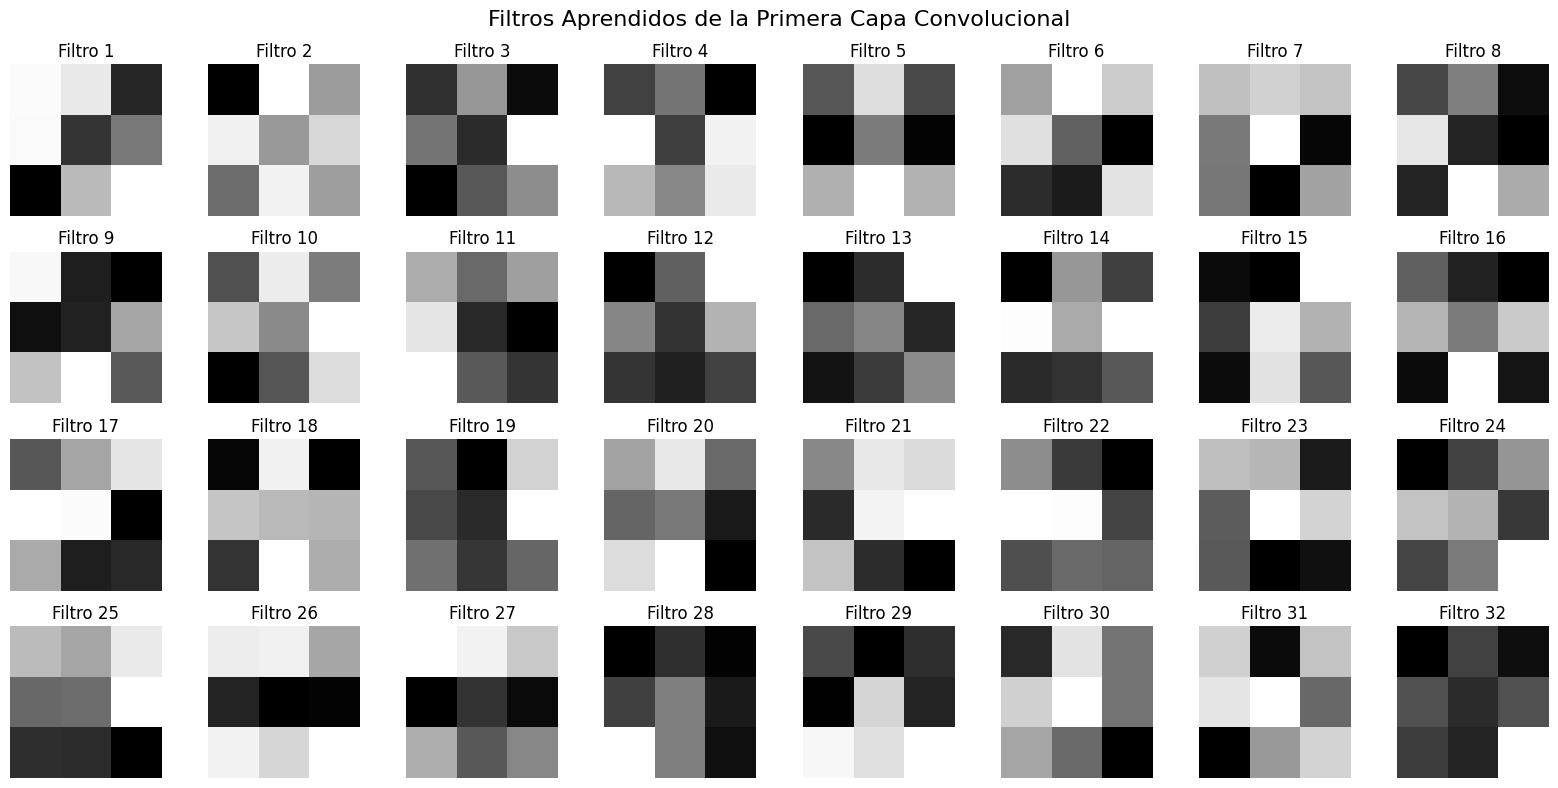

In [81]:
visualizador.visualizar_pesos_modelo(modelo)

Calculando embedding t-SNE...


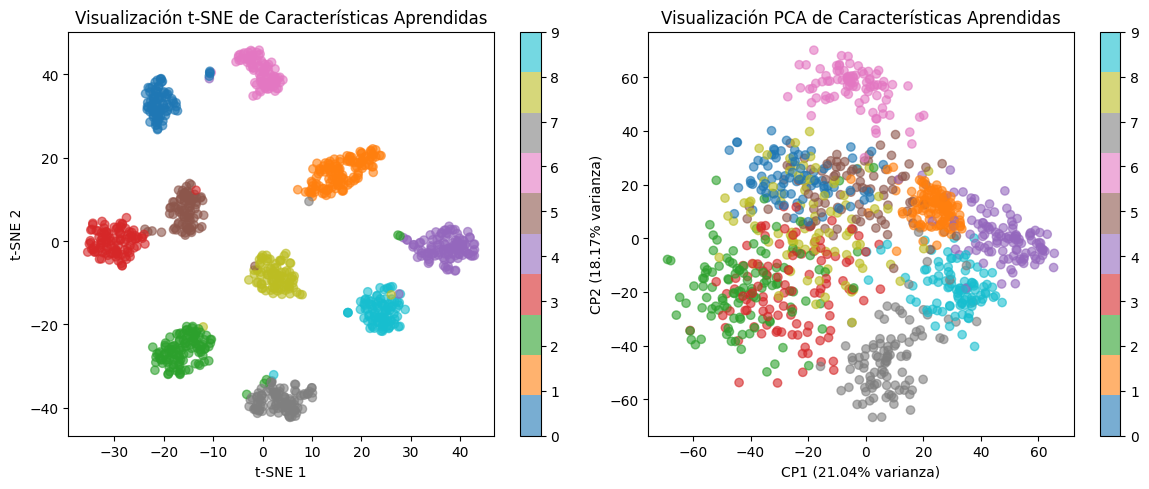

In [82]:
visualizador.visualizar_caracteristicas_aprendidas_tsne(modelo)

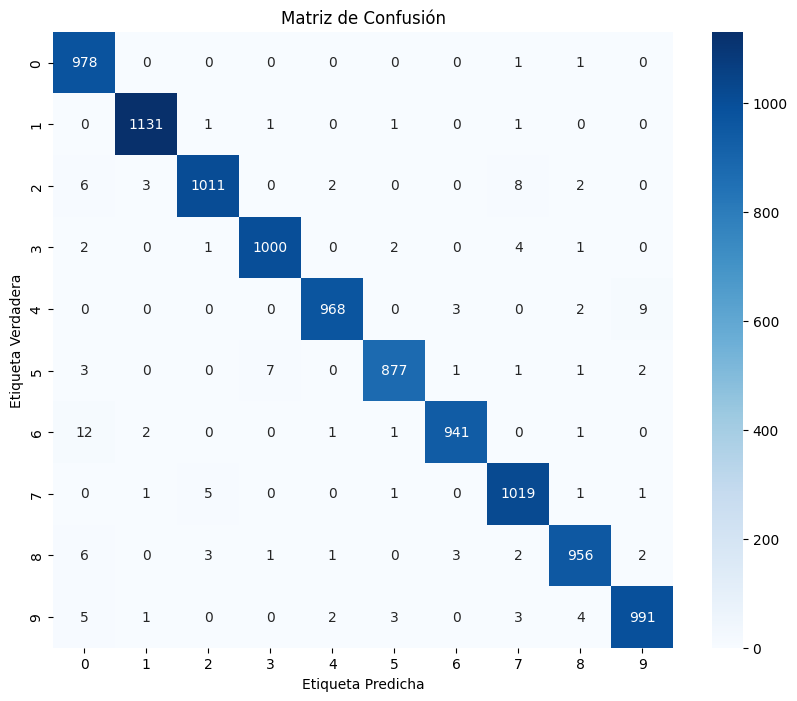


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.98      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Precisión en Prueba: 0.9872


In [83]:
visualizador.crear_matriz_confusion(modelo)